In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import shutil
import time
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from torchvision import transforms, datasets

In [2]:
def plot_wb(model, ranges=None):
  tmp = list(model.named_parameters())
  layers = [(tmp[i], tmp[i+1]) for i in range(0, len(tmp), 2)]

  for w, b in layers:
    if ("conv" in w[0] or "conv" in b[0]) or ("fc" in w[0] or "fc" in b[0]):
      
      w_flatten = w[1].flatten().detach().cpu().numpy()
      b_flatten = b[1].flatten().detach().cpu().numpy()

      fig = plt.figure(figsize=(15,5))

      fig.add_subplot(1,2,1)
      plt.title(w[0])
      plt.hist(w_flatten, bins=100, range=ranges);

      fig.add_subplot(1,2,2)
      plt.title(b[0])
      plt.hist(b_flatten, bins=100, range=ranges);

# I/ Dataset

In [3]:
def load_mnist(BATCH_SIZE=64):
    transform = transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5], std=[0.5])])
            
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    
    # Clear downloading message.
    clear_output()
    
    # Split dataset into training set and validation set.
    train_dataset, val_dataset = random_split(train_dataset, (55000, 5000))
    
    print("Image Shape: {}".format(train_dataset[0][0].numpy().shape), end = '\n\n')
    print("Training Set:   {} samples".format(len(train_dataset)))
    print("Validation Set:   {} samples".format(len(val_dataset)))
    print("Test Set:       {} samples".format(len(test_dataset)))
    
    # Create iterator.
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
    
    # Delete the data/ folder.
    shutil.rmtree('./data')
    
    return (train_loader, val_loader, test_loader)

In [4]:
train_loader, val_loader, test_loader = load_mnist()

Image Shape: (1, 32, 32)

Training Set:   55000 samples
Validation Set:   5000 samples
Test Set:       10000 samples


# II/ Model

In [7]:
class NN(nn.Module):
    
    def __init__(self):
        super(NN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(6)
        self.dp1 = nn.Dropout2d(0.1)
        self.pool1 = nn.AvgPool2d(kernel_size=(2,2), stride=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5))
        self.bn2 = nn.BatchNorm2d(16)
        self.dp2 = nn.Dropout2d(0.1)
        self.pool2 = nn.AvgPool2d(kernel_size=(2,2), stride=2)

        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.bn3 = nn.BatchNorm1d(120)
        self.dp3 = nn.Dropout(0.1)

        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.bn4 = nn.BatchNorm1d(84)
        self.dp4 = nn.Dropout(0.1)

        self.fc3 = nn.Linear(in_features=84, out_features=10)  
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.bn1(x)
        x = self.dp1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.bn2(x)
        x = self.dp2(x)
        x = self.pool2(x)

        x = x.view(-1, 16*5*5)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.bn3(x)
        x = self.dp3(x)

        x = self.fc2(x)
        x = torch.relu(x)
        x = self.bn4(x)
        x = self.dp4(x)

        x = self.fc3(x)
    
        return x

In [8]:
model = NN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
       BatchNorm2d-2            [-1, 6, 28, 28]              12
         Dropout2d-3            [-1, 6, 28, 28]               0
         AvgPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
       BatchNorm2d-6           [-1, 16, 10, 10]              32
         Dropout2d-7           [-1, 16, 10, 10]               0
         AvgPool2d-8             [-1, 16, 5, 5]               0
            Linear-9                  [-1, 120]          48,120
      BatchNorm1d-10                  [-1, 120]             240
          Dropout-11                  [-1, 120]               0
           Linear-12                   [-1, 84]          10,164
      BatchNorm1d-13                   [-1, 84]             168
          Dropout-14                   

# III/ Train

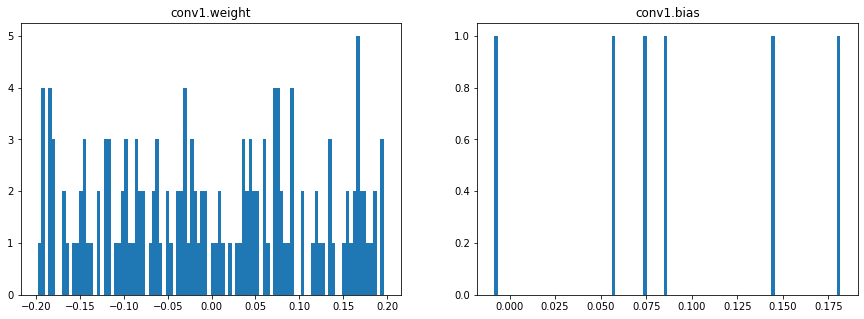

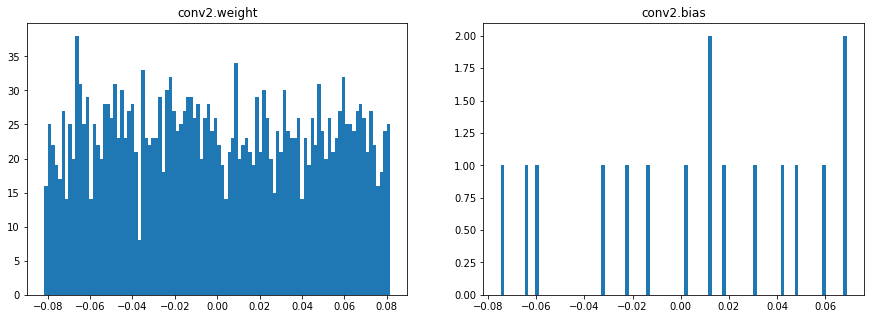

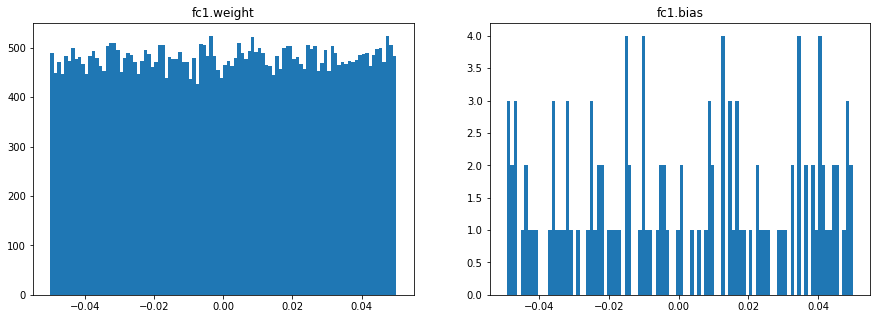

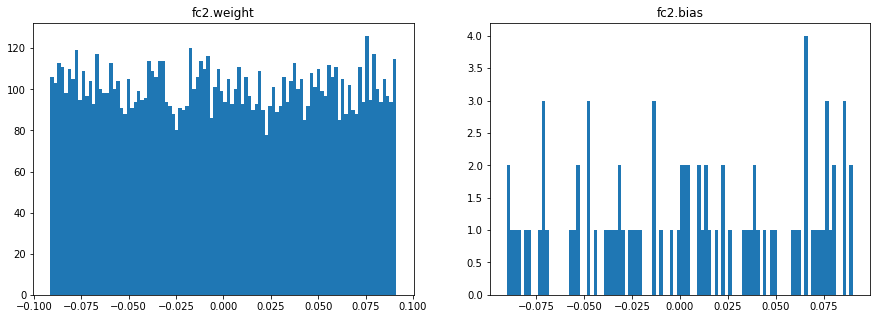

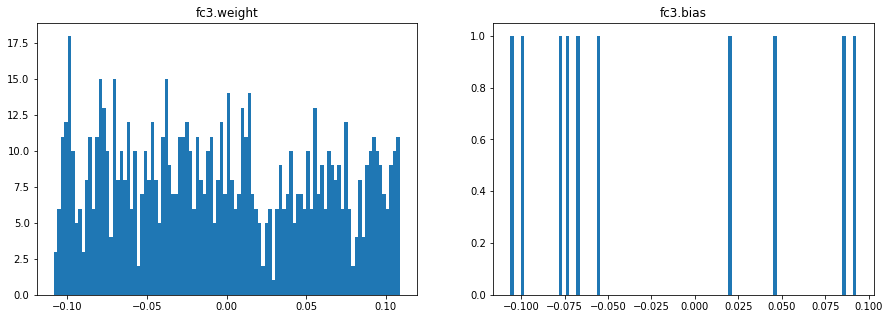

In [9]:
plot_wb(model)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train(EPOCHS, NB_TRAIN_EXAMPLES, NB_VAL_EXAMPLES):
    train_costs, val_costs = [], []

    #Training phase.
    for epoch in range(EPOCHS):

        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Train Acc':^12} | {'Val Loss':^10} | {'Val Acc':^10} | {'Elapsed':^9}")
        print("-"*85)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        #------------------------------------------------
        #                 TRAINING
        #------------------------------------------------

        train_loss, correct_train = 0, 0
        batch_loss, correct_batch, batch_counts = 0, 0, 0
        
        if device == "cuda":
          model.train().cuda()
        
        for step, (inputs, labels) in enumerate(train_loader):
            
            # Load data to GPU.
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients.
            optimizer.zero_grad()
            
            # Forward pass.
            prediction = model(inputs)
            
            # Compute the loss.
            loss = criterion(prediction, labels)
            
            # Backward pass.
            loss.backward()
            
            # Optimize.
            optimizer.step()
            
            # Compute training accuracy.
            _, predicted = torch.max(prediction.data, 1)
            correct_train += (predicted == labels).sum().item()
            correct_batch += (predicted == labels).sum().item()
            
            # Compute batch loss.
            batch_loss += (loss.data.item() * inputs.shape[0])
            train_loss += (loss.data.item() * inputs.shape[0])

            # Print the loss values and time elapsed for every 20 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_loader) - 1):
                
                time_elapsed = time.time() - t0_batch

                print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {correct_batch / batch_counts:^12.6f} | {'-':^10} | {'-':^10} |  {time_elapsed:^9.2f}")
                batch_loss, correct_batch, batch_counts = 0, 0, 0
                t0_batch = time.time()

            batch_counts += inputs.shape[0]

        train_loss /= NB_TRAIN_EXAMPLES
        train_costs.append(train_loss)
        train_acc =  correct_train / NB_TRAIN_EXAMPLES

        print("-"*85)

        #------------------------------------------------
        #                 VALIDATION
        #------------------------------------------------

        val_loss = 0
        correct_val = 0
        
        if device == "cuda":
          model.eval().cuda()
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Load data to GPU.
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass.
                prediction = model(inputs)

                # Compute the loss.
                loss = criterion(prediction, labels)

                # Compute training accuracy.
                _, predicted = torch.max(prediction.data, 1)
                correct_val += (predicted == labels).sum().item()

                # Compute batch loss.
                val_loss += (loss.data.item() * inputs.shape[0])

            val_loss /= NB_VAL_EXAMPLES
            val_costs.append(val_loss)
            val_acc =  correct_val / NB_VAL_EXAMPLES

        time_elapsed = time.time() - t0_epoch
        # print(f"{epoch + 1:^7} | {'-':^7} | {train_loss:^12.6f} | {train_acc:^12.6f} | {val_loss:^10.6f} | {val_acc:^12.6f} | {time_elapsed:^9.2f}")
        # print("-"*85)

        info = "[Epoch {}/{}]: train-loss = {:0.6f} | train-acc = {:0.6f} | val-loss = {:0.6f} | val-acc = {:0.6f} | time_elapsed = {:0.2f}"
        print(info.format(epoch+1, EPOCHS, train_loss, train_acc, val_loss, val_acc, time_elapsed))
                                                                
    # torch.save(model.state_dict(), 'nn_model')  
    return train_costs, val_costs

In [12]:
EPOCHS = 5
NB_TRAIN_EXAMPLES = len(train_loader.dataset)
NB_VAL_EXAMPLES = len(val_loader.dataset)

train_costs, val_costs = train(EPOCHS, NB_TRAIN_EXAMPLES, NB_VAL_EXAMPLES)

 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
   1    |   100   |   0.677662   |   0.832500   |     -      |     -      |    2.40   
   1    |   200   |   0.210222   |   0.945000   |     -      |     -      |    2.28   
   1    |   300   |   0.169764   |   0.949844   |     -      |     -      |    2.27   
   1    |   400   |   0.139689   |   0.958906   |     -      |     -      |    2.19   
   1    |   500   |   0.112016   |   0.969063   |     -      |     -      |    2.25   
   1    |   600   |   0.114198   |   0.964844   |     -      |     -      |    2.28   
   1    |   700   |   0.097772   |   0.971562   |     -      |     -      |    2.29   
   1    |   800   |   0.107316   |   0.967812   |     -      |     -      |    2.24   
   1    |   859   |   0.094468   |   0.957097   |     -      |     -      |    1.30   
---------------------------------------------

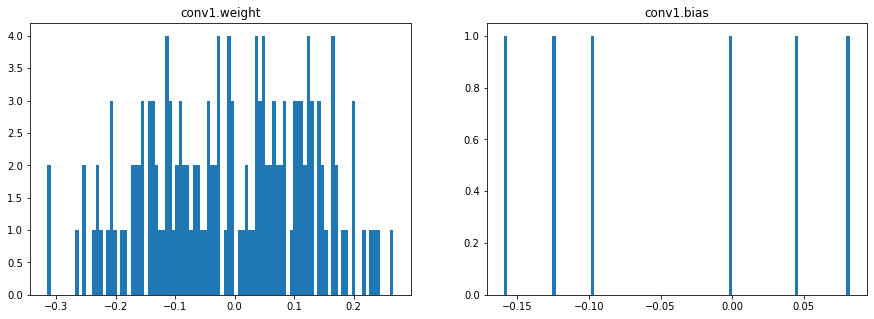

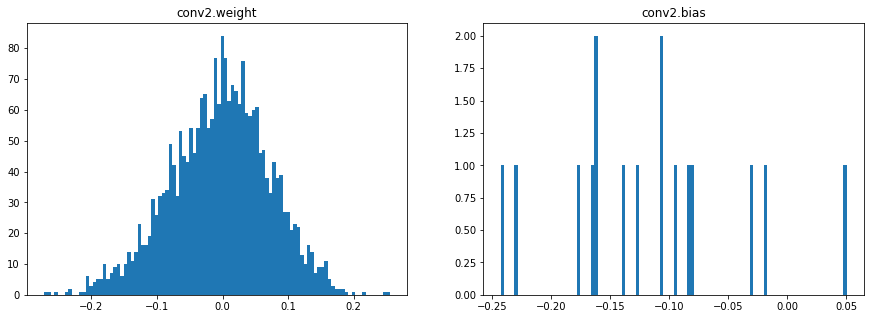

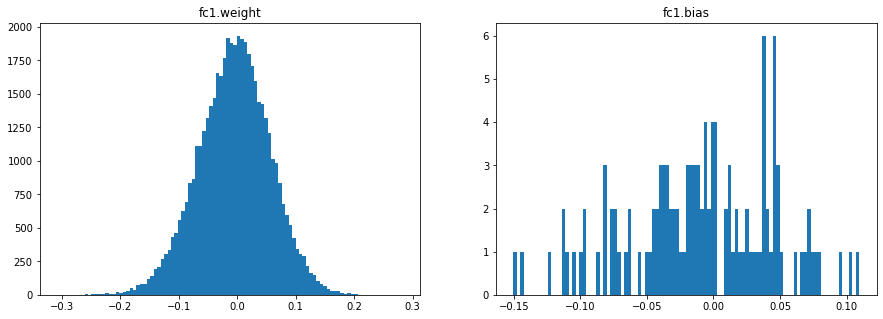

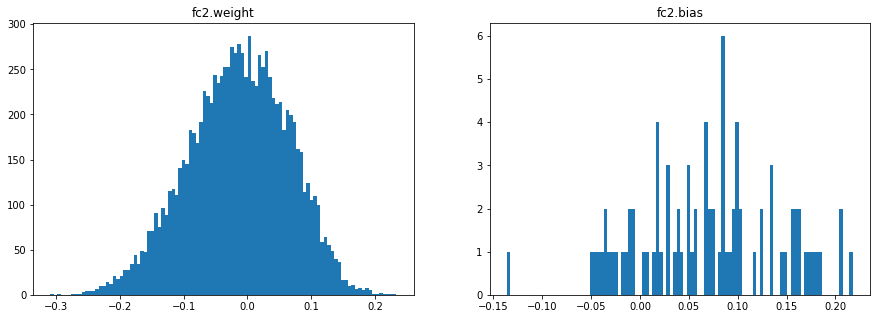

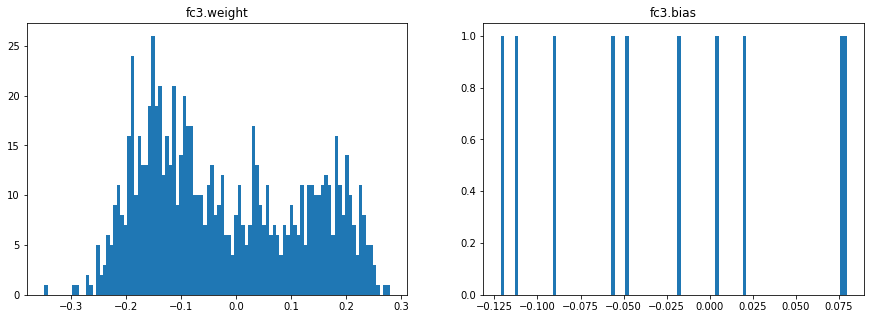

In [13]:
plot_wb(model)

# IV/ Plot

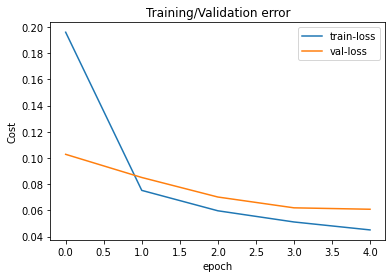

In [14]:
plt.title('Training/Validation error')
plt.ylabel('Cost')
plt.xlabel('epoch')

plt.plot(train_costs)
plt.plot(val_costs)
plt.legend(['train-loss', 'val-loss'], loc='upper right')
plt.show()